### Load packages

In [57]:
import pandas as pd
import numpy as np
import math
import os, sys

# libraries to plot
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
style.use('fivethirtyeight')

pd.set_option('max_colwidth', 800)

### Load Credit Data

#### The dataset contains transactions made by credit cards in September 2013 by european cardholders. It presents transactions that occurred in two days, when there were 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. It contains only numerical input variables which are the result of a PCA transformation (raw data could not be supplied due to confidentiality concerns). 

##### Data acquired from https://www.kaggle.com/mlg-ulb/creditcardfraud/home

In [58]:
credit = pd.read_csv("/Users/decolvin/Downloads/creditcard.csv")
print credit.shape
print 
print credit.dtypes # Check data type for each column

(284807, 31)

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


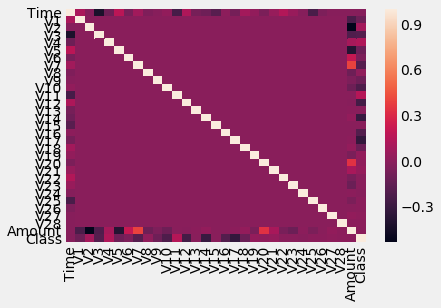

In [61]:
# Check correlations

import seaborn as sns
corr = credit.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [62]:
# Display some records where fraudulent transaction (Class) was 1

credit.loc[credit.Class==1,:].head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


### Check feature importance from PCA variables

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(credit.drop(columns=["Class"]), credit.Class, test_size=0.2, random_state=7)

In [66]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

rf_mod = rf.fit(X_train, y_train)

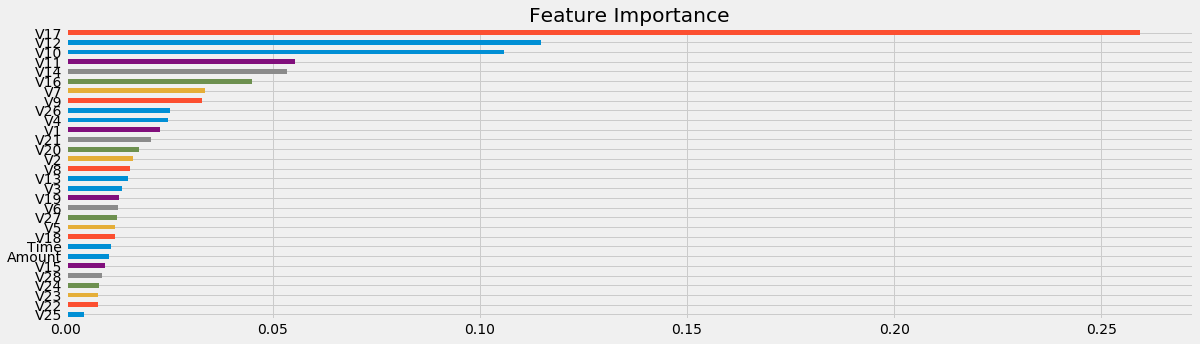

In [67]:
feat_importances = pd.Series(rf_mod.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind='barh', figsize=(18,5), title="Feature Importance")

#### Plot Fraud ID (Class) vs highest correlated variable

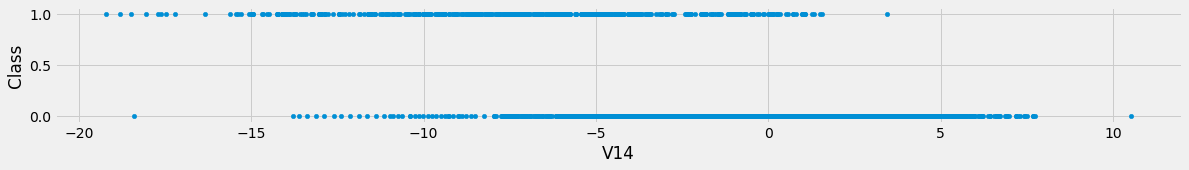

In [68]:
credit.plot(figsize=(18,2), x='V14', y='Class', kind='scatter')

# Part 1: Predict whether a transaction was fraudulent or not

## Classification Modelling

### Logistic Regression

In [69]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression()

mod = log.fit(X_train, y_train)

In [70]:
# Check metrics

from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, f1_score

print("Confusion Matrix")
cm_log = confusion_matrix(y_test, mod.predict(X_test))
print cm_log
print
print("F1 Score = %.2f") %(f1_score(y_test, mod.predict(X_test)))

Confusion Matrix
[[56838    24]
 [   38    62]]

F1 Score = 0.67


### Support Vector Classification

In [72]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

svc = SVC(random_state=7)

## Scale data
scaler = MinMaxScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

svc = SVC(kernel='rbf', shrinking=True)

params_svc = {'C':[1,100,500,1000]}
gs_svc = GridSearchCV(svc,param_grid=params_svc, verbose=0).fit(X_train_std,y_train)

In [73]:
# Check metrics

from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, f1_score

print("Confusion Matrix")
cm_svc = confusion_matrix(y_test, gs_svc.predict(X_test))
print cm_svc
print
print("F1 Score = %.2f") %(f1_score(y_test, gs_svc.best_estimator_.predict(scaler.transform(X_test))))

Confusion Matrix
[[56861     1]
 [  100     0]]

F1 Score = 0.86


### LightGBM (Light Gradient Boosting Machine)

In [74]:
import warnings
warnings.filterwarnings("ignore")

In [75]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

lightbgm = lgb.LGBMClassifier(random_state=7)

param_grid = {'learning_rate': [0.01, 0.1],
               'max_depth': [3, 5, 9],
              'min_child_weight': [1,3,5,7]}

gbm2 = GridSearchCV(lightbgm, param_grid, verbose=0)

gbm2.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=7,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 9], 'min_child_weight': [1, 3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [76]:
# Check metrics

from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix

print("Confusion Matrix")
cm_lightgbm = confusion_matrix(y_test, gbm2.best_estimator_.predict(X_test))
print cm_lightgbm
print
print("F1 Score = %.2f") %(f1_score(y_test, gbm2.best_estimator_.predict(X_test)))

Confusion Matrix
[[56854     8]
 [   21    79]]

F1 Score = 0.84


## Compile Results

In [79]:
results = pd.DataFrame({"Actual":y_test, "Logistic":log.predict(X_test), "SVC":gs_svc.predict(scaler.transform(X_test)),
                       "LightGBM":gbm2.best_estimator_.predict(X_test)})

results.loc[results.Actual == 1,:].sum() # See how many fraudulent cases were predicted

Actual      100
LightGBM     79
Logistic     62
SVC          84
dtype: int64

In [80]:
results.loc[results.Actual == 1,:].head()

,Actual,LightGBM,Logistic,SVC
10690,1,1,1,1
10897,1,1,1,1
154454,1,1,0,1
263877,1,1,1,1
252124,1,1,1,1


#### Support Vector Classification had the highest F1 Score and therefore would be selected as the preferred model. 

# Part 2: Predict how much money was spent given fraudulent transaction

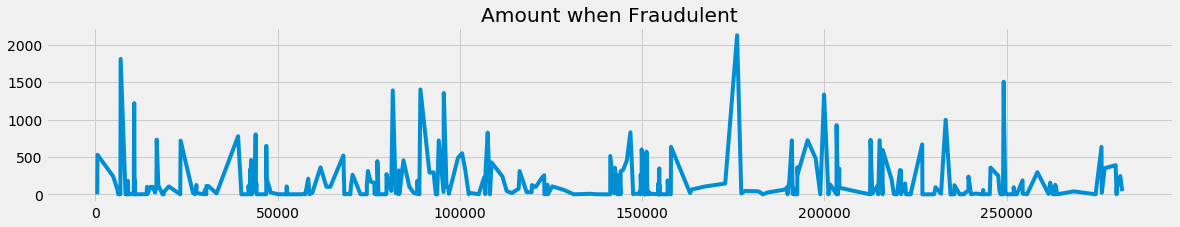

In [113]:
credit.loc[credit.Class==1, "Amount"].plot(figsize=(18,3), title="Amount when Fraudulent")

In [119]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(credit.loc[credit.Class==1,:].drop(columns=["Amount","Class"]), credit.loc[credit.Class==1,'Amount'], test_size=0.2, random_state=7)

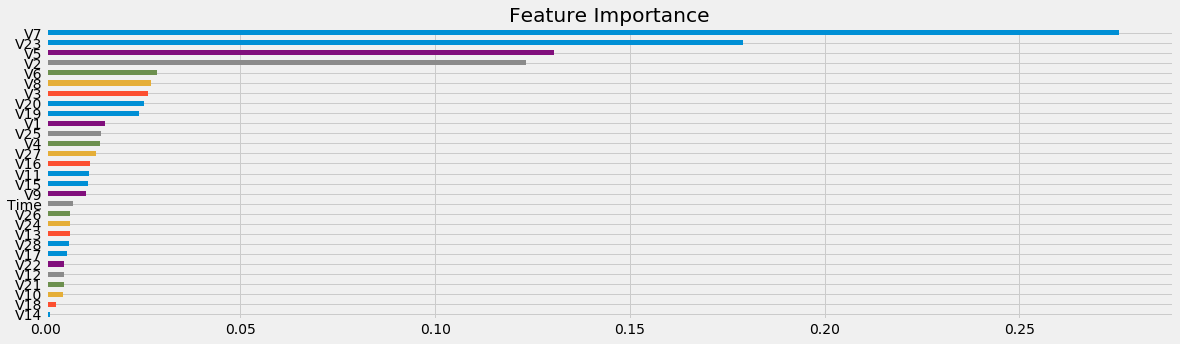

In [120]:
# Check feature importance for Amount variable

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

rf_mod = rf.fit(X_train2, y_train2)

feat_importances = pd.Series(rf_mod.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind='barh', figsize=(18,5), title="Feature Importance")

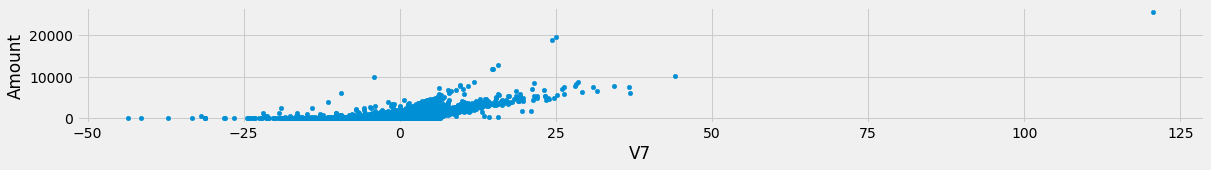

In [121]:
# Plot highest correlating variable with Amount response variable
credit.plot(figsize=(18,2), x="V7", y="Amount", kind='scatter')

## Regression Modeling

### Linear Regression

In [122]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lm = LinearRegression()

mod_lm = lm.fit(X_train2,y_train2)

### Support Vector Regression

In [123]:
# SVR
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

## Scale data
scaler = MinMaxScaler()
X_train_std2 = scaler.fit_transform(X_train2)
X_test_std2 = scaler.transform(X_test2)

svr = SVR(kernel='rbf', shrinking=True)

np.random.seed(7)
params_svr = {'C':[1,100,500,1000], 'epsilon':[0.01,0.1,1,10]}
gs_svr = GridSearchCV(svr,param_grid=params_svr, verbose=0).fit(X_train_std2, y_train2)

### LightGBM

In [124]:
# LightGBM
import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

lightbgm = lgb.LGBMRegressor(random_state=7)

param_grid = {'learning_rate': [0.01, 0.1],
               'max_depth': [3, 5, 9],
              'min_child_weight': [1,3,5,7]}

gbm2 = GridSearchCV(lightbgm, param_grid, verbose=0)

gbm2.fit(X_train2, y_train2)

GridSearchCV(cv=None, error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=7,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 9], 'min_child_weight': [1, 3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### Compare RMSE on Test Set

In [125]:
print("LM RMSE = %.2f") %(math.sqrt(mean_squared_error(y_test, mod_lm.predict(X_test2))))
print("SVR RMSE = %.2f") %(math.sqrt(mean_squared_error(y_test, gs_svr.predict(X_test_std2))))
print("LightGBM RMSE = %.2f") %(math.sqrt(mean_squared_error(y_test, gbm2.predict(X_test2))))

LM RMSE = 89.51
SVR RMSE = 210.42
LightGBM RMSE = 110.31


#### Linear Regression had the lowest RMSE and therefore would be selected as the preferred model. 

## Compile Results

In [139]:
results_reg = pd.DataFrame({"Actual":y_test2,
                           "LM":mod_lm.predict(X_test2),
                          "SVR":gs_svr.predict(X_test_std2),
                          "LightGBM":gbm2.predict(X_test2)})

results_reg.head()

,Actual,LM,LightGBM,SVR
116139,76.94,155.918912,49.152671,56.303658
14338,3.76,36.551116,24.203901,21.458686
94218,720.38,1039.808964,834.948307,141.383450
57615,0.76,24.704203,15.335482,28.133705
11880,1.00,68.762916,-11.035949,35.633550


In [140]:
print("Sum of Amount given fraudulent transaction")
results_reg.sum()

Sum of Amount given fraudulent transaction


Actual      11007.650000
LM          11876.744126
LightGBM    11797.222385
SVR          3939.394643
dtype: float64